# Proyecto NLP

# Identificar los sentimientos que genera, en redes sociales, el referirise a la Selección Colombia de Fútbol


### Diana Patricia Rodríguez González

## Obtención de datos

In [ ]:
import pandas as pd
import tweepy

In [ ]:
# Leer llaves
keys = pd.read_csv("Documents/keys_class_20201107.csv", header=None)
keys = dict(zip(keys[0],keys[1]))

In [ ]:
# Autenticar a través API
auth = tweepy.OAuthHandler(keys['api_key'], keys['api_secret_key'])
auth.set_access_token(keys['access_token'], keys['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
ciudades = pd.read_csv("Downloads/co_small.csv")
ciudades.head()

In [ ]:
all_tweets = [] 
 
for ciudad in ciudades.iterrows():
    c = ciudad[1]
    gc = f"{c.lat},{c.lng},50km"
    nombreCity = c.city

    tweets = tweepy.Cursor(api.search,
                       q=['FCFSeleccionCol -RT'],
                       lang='es',
                       geocode=gc,
                       tweet_mode='extended',
                       include_rts=False).items(30)

    t = []
 
    for tweet in tweets:
        temp = []
        temp.append(tweet.full_text)
        temp.append(tweet.created_at)
        temp.append(nombreCity)
        temp.append(tweet.user.location)
        temp.append(tweet.id)
        temp.append(tweet.place)
        temp.append(tweet.coordinates)
        temp.append(f"https://twitter.com/i/web/status/{tweet.id}")
 
        t.append(temp)

    all_tweets.extend(t)
    print(nombreCity)
    

In [ ]:
data = pd.DataFrame(all_tweets)
data.columns = ['tweet', 'date', 'city', 'user_location', 'id', 'place', 'coordinates','link']
data.head()

In [ ]:
data.to_csv("tweetsCuentaFCFSeleccionCol_3.csv", index=False)

## Unificar datos

In [1]:
import os
import glob
import pandas as pd
os.chdir("C:/Users/Diana Rodriguez/TweetFSelCol")

In [2]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [3]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "tweetsCombinados.csv", index=False, encoding='utf-8-sig')

In [4]:
tweets = pd.read_csv("tweetsCombinados.csv")
tweets.head()

,tweet,date,city,user_location,id,place,coordinates,link
0,Cosas que desnudo la pandemia. Ante eso señore...,2020-11-22 03:18:08,Bogotá,"Bogotá, D.C., Colombia",1330349818988929026,Place(_api=<tweepy.api.API object at 0x000001F...,NaN,https://twitter.com/i/web/status/1330349818988...
1,"@HELIODOPTERO Al técnico si lo cambian, pero a...",2020-11-22 03:03:37,Bogotá,Bogotá,1330346165716590594,NaN,NaN,https://twitter.com/i/web/status/1330346165716...
2,Todos hablan de un técnico en la @FCFSeleccion...,2020-11-22 01:48:11,Bogotá,Bogotá - Colombia,1330327185262059521,NaN,NaN,https://twitter.com/i/web/status/1330327185262...
3,@WRadioColombia @FCFSeleccionCol Club&gt;Selec...,2020-11-22 01:37:45,Bogotá,Bogota Colombia,1330324556821696514,NaN,NaN,https://twitter.com/i/web/status/1330324556821...
4,Alexis Pérez entra con pie derecho al futbol a...,2020-11-21 23:42:47,Bogotá,Bogotá,1330295625959829505,NaN,NaN,https://twitter.com/i/web/status/1330295625959...


In [5]:
tweets.tweet.count()

2795

In [6]:
# Elimina filas duplicadas 
tweets.drop_duplicates(keep = False, inplace = True) 

In [7]:
tweets.tweet.count()

1445

## Preprocesamiento de Twitter

In [8]:
#Preprocesamiento de Twitter
import re
 
pattern1 = '?P<pic>pic.twitter.com/[^\s]+'
pattern2 = '?P<url>https?://[^\s]+'
 
def text_clean(row):
    text = row['tweet']

    links = [tuple(j for j in i if j)[-1] for i in re.findall(f"({pattern1})|({pattern2})",text)]
    for link in links:
        text = text.replace(link,"")

    hashtags = [interaction for interaction in text.split() if interaction.startswith("#")]
    for hashtag in hashtags:
        text = text.replace(hashtag,"")

    mentions = [interaction for interaction in text.split() if interaction.startswith("@")]
    for mention in mentions:
        text = text.replace(mention,"")

    return text, links, hashtags, mentions

In [9]:
#Crear columnas adicionales para obtener en clean los tweets sin links, son hashtags ni menciones.
tweets[['clean', 'links', 'hashtags', 'mentions']] = tweets.apply(text_clean, axis=1, result_type='expand')

tweets.head()

,tweet,date,city,user_location,id,place,coordinates,link,clean,links,hashtags,mentions
0,Cosas que desnudo la pandemia. Ante eso señore...,2020-11-22 03:18:08,Bogotá,"Bogotá, D.C., Colombia",1330349818988929026,Place(_api=<tweepy.api.API object at 0x000001F...,NaN,https://twitter.com/i/web/status/1330349818988...,Cosas que desnudo la pandemia. Ante eso señore...,[https://t.co/ws4tKWxDca],[],"[@Dimayor, @FCFSeleccionCol]"
1,"@HELIODOPTERO Al técnico si lo cambian, pero a...",2020-11-22 03:03:37,Bogotá,Bogotá,1330346165716590594,NaN,NaN,https://twitter.com/i/web/status/1330346165716...,"Al técnico si lo cambian, pero al presidente ...",[],[],"[@HELIODOPTERO, @IvanDuque, @FCFSeleccionCol]"
2,Todos hablan de un técnico en la @FCFSeleccion...,2020-11-22 01:48:11,Bogotá,Bogotá - Colombia,1330327185262059521,NaN,NaN,https://twitter.com/i/web/status/1330327185262...,Todos hablan de un técnico en la Por qué no s...,[],[],[@FCFSeleccionCol.]
3,@WRadioColombia @FCFSeleccionCol Club&gt;Selec...,2020-11-22 01:37:45,Bogotá,Bogota Colombia,1330324556821696514,NaN,NaN,https://twitter.com/i/web/status/1330324556821...,Club&gt;Selección,[],[],"[@WRadioColombia, @FCFSeleccionCol]"
4,Alexis Pérez entra con pie derecho al futbol a...,2020-11-21 23:42:47,Bogotá,Bogotá,1330295625959829505,NaN,NaN,https://twitter.com/i/web/status/1330295625959...,Alexis Pérez entra con pie derecho al futbol a...,[https://t.co/GzAwcQN6ba],[],"[@FCFSeleccionCol, @FCF_Oficial]"


In [10]:
import regex
import emoji
 
def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
 
    return emoji_list
 
tweets['emojis'] = tweets['clean'].apply(lambda text: get_emojis(text))
tweets.head()

,tweet,date,city,user_location,id,place,coordinates,link,clean,links,hashtags,mentions,emojis
0,Cosas que desnudo la pandemia. Ante eso señore...,2020-11-22 03:18:08,Bogotá,"Bogotá, D.C., Colombia",1330349818988929026,Place(_api=<tweepy.api.API object at 0x000001F...,NaN,https://twitter.com/i/web/status/1330349818988...,Cosas que desnudo la pandemia. Ante eso señore...,[https://t.co/ws4tKWxDca],[],"[@Dimayor, @FCFSeleccionCol]",[]
1,"@HELIODOPTERO Al técnico si lo cambian, pero a...",2020-11-22 03:03:37,Bogotá,Bogotá,1330346165716590594,NaN,NaN,https://twitter.com/i/web/status/1330346165716...,"Al técnico si lo cambian, pero al presidente ...",[],[],"[@HELIODOPTERO, @IvanDuque, @FCFSeleccionCol]",[]
2,Todos hablan de un técnico en la @FCFSeleccion...,2020-11-22 01:48:11,Bogotá,Bogotá - Colombia,1330327185262059521,NaN,NaN,https://twitter.com/i/web/status/1330327185262...,Todos hablan de un técnico en la Por qué no s...,[],[],[@FCFSeleccionCol.],[]
3,@WRadioColombia @FCFSeleccionCol Club&gt;Selec...,2020-11-22 01:37:45,Bogotá,Bogota Colombia,1330324556821696514,NaN,NaN,https://twitter.com/i/web/status/1330324556821...,Club&gt;Selección,[],[],"[@WRadioColombia, @FCFSeleccionCol]",[]
4,Alexis Pérez entra con pie derecho al futbol a...,2020-11-21 23:42:47,Bogotá,Bogotá,1330295625959829505,NaN,NaN,https://twitter.com/i/web/status/1330295625959...,Alexis Pérez entra con pie derecho al futbol a...,[https://t.co/GzAwcQN6ba],[],"[@FCFSeleccionCol, @FCF_Oficial]",[]


## Preprocesamiento de Texto

In [11]:
import re

from nltk.corpus import stopwords
stopwords = stopwords.words('spanish')

from nltk.stem.snowball import SnowballStemmer
spanishStemmer=SnowballStemmer("spanish")

import nltk 
from nltk.stem import WordNetLemmatizer 
#nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

In [12]:
stopwords.append("colombia")
stopwords.append("selección")
stopwords.append("seleccion")
stopwords.append("ó")
stopwords.append("q")
stopwords.append("do")
stopwords.append("ma")
stopwords.append("\n")

In [13]:
def preprocesotext(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join(palabra for palabra in texto.split() if palabra not in stopwords)
    return texto

In [14]:
tweets['preprocesado'] = tweets['clean'].apply(lambda fila: preprocesotext(fila)) 
tweets.head()

,tweet,date,city,user_location,id,place,coordinates,link,clean,links,hashtags,mentions,emojis,preprocesado
0,Cosas que desnudo la pandemia. Ante eso señore...,2020-11-22 03:18:08,Bogotá,"Bogotá, D.C., Colombia",1330349818988929026,Place(_api=<tweepy.api.API object at 0x000001F...,NaN,https://twitter.com/i/web/status/1330349818988...,Cosas que desnudo la pandemia. Ante eso señore...,[https://t.co/ws4tKWxDca],[],"[@Dimayor, @FCFSeleccionCol]",[],cosas desnudo pandemia señores federación espe...
1,"@HELIODOPTERO Al técnico si lo cambian, pero a...",2020-11-22 03:03:37,Bogotá,Bogotá,1330346165716590594,NaN,NaN,https://twitter.com/i/web/status/1330346165716...,"Al técnico si lo cambian, pero al presidente ...",[],[],"[@HELIODOPTERO, @IvanDuque, @FCFSeleccionCol]",[],técnico si cambian presidente ahí apoyado narc...
2,Todos hablan de un técnico en la @FCFSeleccion...,2020-11-22 01:48:11,Bogotá,Bogotá - Colombia,1330327185262059521,NaN,NaN,https://twitter.com/i/web/status/1330327185262...,Todos hablan de un técnico en la Por qué no s...,[],[],[@FCFSeleccionCol.],[],hablan técnico habla directivos quiénes elijen...
3,@WRadioColombia @FCFSeleccionCol Club&gt;Selec...,2020-11-22 01:37:45,Bogotá,Bogota Colombia,1330324556821696514,NaN,NaN,https://twitter.com/i/web/status/1330324556821...,Club&gt;Selección,[],[],"[@WRadioColombia, @FCFSeleccionCol]",[],club gt
4,Alexis Pérez entra con pie derecho al futbol a...,2020-11-21 23:42:47,Bogotá,Bogotá,1330295625959829505,NaN,NaN,https://twitter.com/i/web/status/1330295625959...,Alexis Pérez entra con pie derecho al futbol a...,[https://t.co/GzAwcQN6ba],[],"[@FCFSeleccionCol, @FCF_Oficial]",[],alexis pérez entra pie derecho futbol argentin...


In [15]:
def lema(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = [lemmatizer.lemmatize(palabra) for palabra in texto.split() if palabra not in stopwords]
    return texto


In [16]:
tweets['lema'] = tweets['clean'].apply(lambda fila: lema(fila)) 
tweets.head()

,tweet,date,city,user_location,id,place,coordinates,link,clean,links,hashtags,mentions,emojis,preprocesado,lema
0,Cosas que desnudo la pandemia. Ante eso señore...,2020-11-22 03:18:08,Bogotá,"Bogotá, D.C., Colombia",1330349818988929026,Place(_api=<tweepy.api.API object at 0x000001F...,NaN,https://twitter.com/i/web/status/1330349818988...,Cosas que desnudo la pandemia. Ante eso señore...,[https://t.co/ws4tKWxDca],[],"[@Dimayor, @FCFSeleccionCol]",[],cosas desnudo pandemia señores federación espe...,"[cosas, desnudo, pandemia, señores, federación..."
1,"@HELIODOPTERO Al técnico si lo cambian, pero a...",2020-11-22 03:03:37,Bogotá,Bogotá,1330346165716590594,NaN,NaN,https://twitter.com/i/web/status/1330346165716...,"Al técnico si lo cambian, pero al presidente ...",[],[],"[@HELIODOPTERO, @IvanDuque, @FCFSeleccionCol]",[],técnico si cambian presidente ahí apoyado narc...,"[técnico, si, cambian, presidente, ahí, apoyad..."
2,Todos hablan de un técnico en la @FCFSeleccion...,2020-11-22 01:48:11,Bogotá,Bogotá - Colombia,1330327185262059521,NaN,NaN,https://twitter.com/i/web/status/1330327185262...,Todos hablan de un técnico en la Por qué no s...,[],[],[@FCFSeleccionCol.],[],hablan técnico habla directivos quiénes elijen...,"[hablan, técnico, habla, directivos, quiénes, ..."
3,@WRadioColombia @FCFSeleccionCol Club&gt;Selec...,2020-11-22 01:37:45,Bogotá,Bogota Colombia,1330324556821696514,NaN,NaN,https://twitter.com/i/web/status/1330324556821...,Club&gt;Selección,[],[],"[@WRadioColombia, @FCFSeleccionCol]",[],club gt,"[club, gt]"
4,Alexis Pérez entra con pie derecho al futbol a...,2020-11-21 23:42:47,Bogotá,Bogotá,1330295625959829505,NaN,NaN,https://twitter.com/i/web/status/1330295625959...,Alexis Pérez entra con pie derecho al futbol a...,[https://t.co/GzAwcQN6ba],[],"[@FCFSeleccionCol, @FCF_Oficial]",[],alexis pérez entra pie derecho futbol argentin...,"[alexis, pérez, entra, pie, derecho, futbol, a..."


## Modelados de Temas

In [17]:
#Entrenar el Modelo
import pyLDAvis.gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from pprint import pprint

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [18]:
# Crear una representación de los documentos en forma de diccionario
dictionary = Dictionary(tweets['lema'].values)

# Filtrar palabras muy frecuentes o infrecuentes
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in tweets['lema'].values]

# Train the topic model
model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=800, iterations=300)

In [19]:
# Imprimir temas
model.print_topics(num_words=15)

[(0,
  '0.035*"queiroz" + 0.026*"dt" + 0.016*"solo" + 0.015*"james" + 0.015*"salida" + 0.012*"va" + 0.012*"aquí" + 0.010*"dirigir" + 0.010*"carlos" + 0.009*"gallardo" + 0.008*"mejor" + 0.008*"si" + 0.008*"periodistas" + 0.008*"ahora" + 0.007*"gol"'),
 (1,
  '0.031*"cualquier" + 0.027*"técnico" + 0.023*"país" + 0.022*"puede" + 0.018*"debe" + 0.017*"si" + 0.016*"antonio" + 0.016*"carlos" + 0.016*"vélez" + 0.015*"saben" + 0.015*"europeo" + 0.015*"oscar" + 0.014*"muñoz" + 0.014*"londoño" + 0.014*"busquen"'),
 (2,
  '0.026*"jugadores" + 0.023*"técnico" + 0.020*"si" + 0.019*"fútbol" + 0.013*"así" + 0.011*"siempre" + 0.011*"hace" + 0.009*"brasil" + 0.009*"colombiano" + 0.009*"ecuador" + 0.008*"jugar" + 0.008*"equipo" + 0.008*"ahí" + 0.007*"partidos" + 0.007*"hacer"')]

In [20]:
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Emojis más usados

In [21]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
 
import matplotlib.pyplot as plt
%matplotlib inline
init_notebook_mode(connected=True)

C:\ProgramData\Anaconda3\lib\site-packages\nbformat\notebooknode.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working



In [22]:
#Emojis preprocesados
from collections import Counter
 
temp_emojis = pd.DataFrame(list(zip(Counter(sum(tweets.emojis.values,[])).keys(),Counter(sum(tweets.emojis.values,[])).values())))
temp_emojis.columns = ['emoji', 'cantidad']
temp_emojis.sort_values('cantidad', ascending=False, inplace=True)
temp_emojis.head()


,emoji,cantidad
8,🤣,96
11,🇨🇴,60
17,🤡,49
69,👇,25
4,😂,24


In [23]:
trace = go.Bar(x=temp_emojis.emoji.values[:15],
               y=temp_emojis.cantidad.values[:15])
 
layout = go.Layout(title='Emojis más usados')
 
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [24]:
#Para solucionar error --> AttributeError: Can only use .dt accessor with datetimelike values
tweets['Date'] = pd.to_datetime(tweets['date'], errors='coerce')

In [25]:
tweets['fecha'] = tweets.Date.dt.date
datafecha = pd.DataFrame(tweets.fecha.value_counts()).reset_index()
datafecha.columns = ['fecha', 'cantidad']
datafecha = datafecha.sort_values('fecha')
datafecha

,fecha,cantidad
10,2020-11-13,20
12,2020-11-14,8
13,2020-11-16,3
8,2020-11-17,49
5,2020-11-18,104
2,2020-11-19,176
1,2020-11-20,301
0,2020-11-21,344
7,2020-11-22,74
11,2020-11-23,15


In [26]:
temp = pd.DataFrame(tweets.groupby(['city', 'fecha'])['city'].count())
temp.columns = ['cnt']
temp.reset_index(inplace=True)

In [27]:
traces = []

city_color_dict = {'Bogotá': "#f4ce26",
                    'Medellín': "#f45626",
                    'Cali': "#26c4f4",
                    'Barranquilla': "#26f445",
                    'Bucaramanga': "#f426df",
                    'Cartagena': "#d5f426",
                    'Cúcuta': "#961540",
                    'Pereira': "#fa0505",
                    'Santa Marta': "#c3fab4",
                    'Ibagué': "#b4faf8",
                    'Pasto': "#bcb4fa",
                    'Manizales': "#eca1f7",
                    'Villavicencio': "#2e5946",
                    'Neiva': "#e8b3c4",
                    'Armenia': "#ebd1ca",
                    'Valledupar': "#fa9702",
                    'Montería': "#fcfabb",
                    'Sincelejo': "#b6c99f",
                    'Popayán': "#2cab5f",
                    'Tunja': "#d8b1f0",
                    'Ríohacha': "#ad0309",
                    'Florencia': "#cbff47",
                    'Quibdó': "#d4ff47",
                    'Arauca': "#b85433",
                    'Yopal': "#b4b833",
                    'Leticia': "#33b8a0",
                    'San Andrés': "#267e91",
                    'San José del Guaviare': "#c973ff",
                    'Mocoa': "#ff73f6",
                    'Puerto Carreño': "#bdbf2e",
                    'Mitú': "#7cc900",
                    'Inírida': "#f7f5cb"}

for city in temp['city'].unique():
    trace= go.Scatter(
                        x=temp[temp['city']==city].fecha.values,
                        y=temp[temp['city']==city].cnt.values,
                        mode='lines', 
                        line = {'color': city_color_dict[city], 'width': 1.2},
                        name=city
                    ) 

    traces.append(trace)
    
layout = go.Layout(title='Numero de tweets por Ciudad')

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

## Análisis de Sentimiento basado en Redes Neuronales

In [28]:
from flair.models import TextClassifier
from flair.data import Sentence

In [29]:
classifier = TextClassifier.load('sentiment')

def sent_flair(texto):
    sentence = Sentence(texto)
    classifier.predict(sentence)
    result = sentence.labels[0]
    label = result.value
    score = result.score
    if label == 'POSITIVE':
        return score
    if label == 'NEGATIVE':
        return -1 * score
    return score

tweets['sent_flair'] = tweets['clean'].apply(lambda valor: sent_flair(valor))
tweets.head()

2020-11-27 22:23:22,218 loading file C:\Users\Diana Rodriguez\.flair\models\sentiment-en-mix-distillbert_3.1.pt


,tweet,date,city,user_location,id,place,coordinates,link,clean,links,hashtags,mentions,emojis,preprocesado,lema,Date,fecha,sent_flair
0,Cosas que desnudo la pandemia. Ante eso señore...,2020-11-22 03:18:08,Bogotá,"Bogotá, D.C., Colombia",1330349818988929026,Place(_api=<tweepy.api.API object at 0x000001F...,NaN,https://twitter.com/i/web/status/1330349818988...,Cosas que desnudo la pandemia. Ante eso señore...,[https://t.co/ws4tKWxDca],[],"[@Dimayor, @FCFSeleccionCol]",[],cosas desnudo pandemia señores federación espe...,"[cosas, desnudo, pandemia, señores, federación...",2020-11-22 03:18:08,2020-11-22,0.989689
1,"@HELIODOPTERO Al técnico si lo cambian, pero a...",2020-11-22 03:03:37,Bogotá,Bogotá,1330346165716590594,NaN,NaN,https://twitter.com/i/web/status/1330346165716...,"Al técnico si lo cambian, pero al presidente ...",[],[],"[@HELIODOPTERO, @IvanDuque, @FCFSeleccionCol]",[],técnico si cambian presidente ahí apoyado narc...,"[técnico, si, cambian, presidente, ahí, apoyad...",2020-11-22 03:03:37,2020-11-22,0.996801
2,Todos hablan de un técnico en la @FCFSeleccion...,2020-11-22 01:48:11,Bogotá,Bogotá - Colombia,1330327185262059521,NaN,NaN,https://twitter.com/i/web/status/1330327185262...,Todos hablan de un técnico en la Por qué no s...,[],[],[@FCFSeleccionCol.],[],hablan técnico habla directivos quiénes elijen...,"[hablan, técnico, habla, directivos, quiénes, ...",2020-11-22 01:48:11,2020-11-22,-0.655975
3,@WRadioColombia @FCFSeleccionCol Club&gt;Selec...,2020-11-22 01:37:45,Bogotá,Bogota Colombia,1330324556821696514,NaN,NaN,https://twitter.com/i/web/status/1330324556821...,Club&gt;Selección,[],[],"[@WRadioColombia, @FCFSeleccionCol]",[],club gt,"[club, gt]",2020-11-22 01:37:45,2020-11-22,0.998875
4,Alexis Pérez entra con pie derecho al futbol a...,2020-11-21 23:42:47,Bogotá,Bogotá,1330295625959829505,NaN,NaN,https://twitter.com/i/web/status/1330295625959...,Alexis Pérez entra con pie derecho al futbol a...,[https://t.co/GzAwcQN6ba],[],"[@FCFSeleccionCol, @FCF_Oficial]",[],alexis pérez entra pie derecho futbol argentin...,"[alexis, pérez, entra, pie, derecho, futbol, a...",2020-11-21 23:42:47,2020-11-21,0.999266


In [30]:
def label_flair(texto):
    sentence = Sentence(texto)
    classifier.predict(sentence)
    result = sentence.labels[0]
    label = result.value
    score = result.score
    return label

tweets['label_flair'] = tweets['clean'].apply(lambda valor: label_flair(valor))
tweets.head()

,tweet,date,city,user_location,id,place,coordinates,link,clean,links,hashtags,mentions,emojis,preprocesado,lema,Date,fecha,sent_flair,label_flair
0,Cosas que desnudo la pandemia. Ante eso señore...,2020-11-22 03:18:08,Bogotá,"Bogotá, D.C., Colombia",1330349818988929026,Place(_api=<tweepy.api.API object at 0x000001F...,NaN,https://twitter.com/i/web/status/1330349818988...,Cosas que desnudo la pandemia. Ante eso señore...,[https://t.co/ws4tKWxDca],[],"[@Dimayor, @FCFSeleccionCol]",[],cosas desnudo pandemia señores federación espe...,"[cosas, desnudo, pandemia, señores, federación...",2020-11-22 03:18:08,2020-11-22,0.989689,POSITIVE
1,"@HELIODOPTERO Al técnico si lo cambian, pero a...",2020-11-22 03:03:37,Bogotá,Bogotá,1330346165716590594,NaN,NaN,https://twitter.com/i/web/status/1330346165716...,"Al técnico si lo cambian, pero al presidente ...",[],[],"[@HELIODOPTERO, @IvanDuque, @FCFSeleccionCol]",[],técnico si cambian presidente ahí apoyado narc...,"[técnico, si, cambian, presidente, ahí, apoyad...",2020-11-22 03:03:37,2020-11-22,0.996801,POSITIVE
2,Todos hablan de un técnico en la @FCFSeleccion...,2020-11-22 01:48:11,Bogotá,Bogotá - Colombia,1330327185262059521,NaN,NaN,https://twitter.com/i/web/status/1330327185262...,Todos hablan de un técnico en la Por qué no s...,[],[],[@FCFSeleccionCol.],[],hablan técnico habla directivos quiénes elijen...,"[hablan, técnico, habla, directivos, quiénes, ...",2020-11-22 01:48:11,2020-11-22,-0.655975,NEGATIVE
3,@WRadioColombia @FCFSeleccionCol Club&gt;Selec...,2020-11-22 01:37:45,Bogotá,Bogota Colombia,1330324556821696514,NaN,NaN,https://twitter.com/i/web/status/1330324556821...,Club&gt;Selección,[],[],"[@WRadioColombia, @FCFSeleccionCol]",[],club gt,"[club, gt]",2020-11-22 01:37:45,2020-11-22,0.998875,POSITIVE
4,Alexis Pérez entra con pie derecho al futbol a...,2020-11-21 23:42:47,Bogotá,Bogotá,1330295625959829505,NaN,NaN,https://twitter.com/i/web/status/1330295625959...,Alexis Pérez entra con pie derecho al futbol a...,[https://t.co/GzAwcQN6ba],[],"[@FCFSeleccionCol, @FCF_Oficial]",[],alexis pérez entra pie derecho futbol argentin...,"[alexis, pérez, entra, pie, derecho, futbol, a...",2020-11-21 23:42:47,2020-11-21,0.999266,POSITIVE


In [31]:
df_positivo = tweets[tweets['label_flair']=='POSITIVE']
df_positivo.head()

,tweet,date,city,user_location,id,place,coordinates,link,clean,links,hashtags,mentions,emojis,preprocesado,lema,Date,fecha,sent_flair,label_flair
0,Cosas que desnudo la pandemia. Ante eso señore...,2020-11-22 03:18:08,Bogotá,"Bogotá, D.C., Colombia",1330349818988929026,Place(_api=<tweepy.api.API object at 0x000001F...,NaN,https://twitter.com/i/web/status/1330349818988...,Cosas que desnudo la pandemia. Ante eso señore...,[https://t.co/ws4tKWxDca],[],"[@Dimayor, @FCFSeleccionCol]",[],cosas desnudo pandemia señores federación espe...,"[cosas, desnudo, pandemia, señores, federación...",2020-11-22 03:18:08,2020-11-22,0.989689,POSITIVE
1,"@HELIODOPTERO Al técnico si lo cambian, pero a...",2020-11-22 03:03:37,Bogotá,Bogotá,1330346165716590594,NaN,NaN,https://twitter.com/i/web/status/1330346165716...,"Al técnico si lo cambian, pero al presidente ...",[],[],"[@HELIODOPTERO, @IvanDuque, @FCFSeleccionCol]",[],técnico si cambian presidente ahí apoyado narc...,"[técnico, si, cambian, presidente, ahí, apoyad...",2020-11-22 03:03:37,2020-11-22,0.996801,POSITIVE
3,@WRadioColombia @FCFSeleccionCol Club&gt;Selec...,2020-11-22 01:37:45,Bogotá,Bogota Colombia,1330324556821696514,NaN,NaN,https://twitter.com/i/web/status/1330324556821...,Club&gt;Selección,[],[],"[@WRadioColombia, @FCFSeleccionCol]",[],club gt,"[club, gt]",2020-11-22 01:37:45,2020-11-22,0.998875,POSITIVE
4,Alexis Pérez entra con pie derecho al futbol a...,2020-11-21 23:42:47,Bogotá,Bogotá,1330295625959829505,NaN,NaN,https://twitter.com/i/web/status/1330295625959...,Alexis Pérez entra con pie derecho al futbol a...,[https://t.co/GzAwcQN6ba],[],"[@FCFSeleccionCol, @FCF_Oficial]",[],alexis pérez entra pie derecho futbol argentin...,"[alexis, pérez, entra, pie, derecho, futbol, a...",2020-11-21 23:42:47,2020-11-21,0.999266,POSITIVE
6,Que tal la jugada... @nacionaloficial y @FCFSe...,2020-11-21 21:38:37,Bogotá,bogota,1330264379556831237,NaN,NaN,https://twitter.com/i/web/status/1330264379556...,Que tal la jugada... y pa que practiquen si ...,[https://t.co/rDap6mNYc6],[],"[@nacionaloficial, @FCFSeleccionCol]",[],tal jugada pa practiquen si saben hacer balon ...,"[tal, jugada, pa, practiquen, si, saben, hacer...",2020-11-21 21:38:37,2020-11-21,0.966885,POSITIVE


In [36]:
import numpy as np

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

#from nltk.corpus import stopwords
#stopwords = stopwords.words('spanish')

import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import display

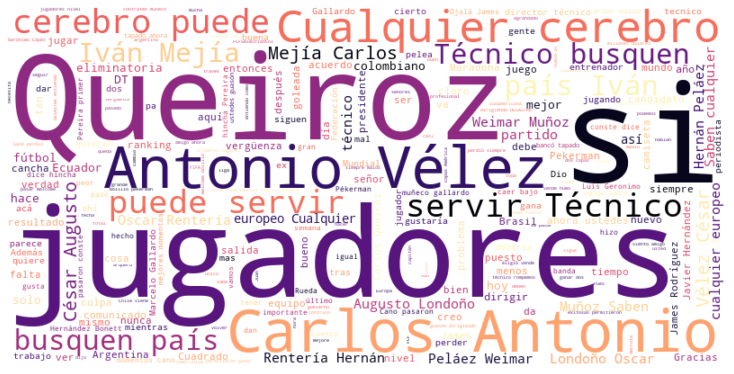

In [42]:
palabras = df_positivo.clean.str.cat(sep=" ")
wordcloud = WordCloud(width=800, height=400,
                     max_font_size=150, max_words=250,
                     background_color='white', colormap='magma',
                     stopwords=stopwords).generate(palabras)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [43]:
df_negativo = tweets[tweets['label_flair']=='NEGATIVE']
df_negativo.head()

,tweet,date,city,user_location,id,place,coordinates,link,clean,links,hashtags,mentions,emojis,preprocesado,lema,Date,fecha,sent_flair,label_flair
2,Todos hablan de un técnico en la @FCFSeleccion...,2020-11-22 01:48:11,Bogotá,Bogotá - Colombia,1330327185262059521,NaN,NaN,https://twitter.com/i/web/status/1330327185262...,Todos hablan de un técnico en la Por qué no s...,[],[],[@FCFSeleccionCol.],[],hablan técnico habla directivos quiénes elijen...,"[hablan, técnico, habla, directivos, quiénes, ...",2020-11-22 01:48:11,2020-11-22,-0.655975,NEGATIVE
5,No pudo haber caído más bajo este @FCBarcelona...,2020-11-21 21:57:52,Bogotá,"Bogotá, Colombia",1330269223839555591,Place(_api=<tweepy.api.API object at 0x000001F...,NaN,https://twitter.com/i/web/status/1330269223839...,No pudo haber caído más bajo este . Cada vez ...,[],[],"[@FCBarcelona_es, @FCFSeleccionCol, @TeamMessi]",[],pudo haber caído bajo cada vez juega peor sang...,"[pudo, haber, caído, bajo, cada, vez, juega, p...",2020-11-21 21:57:52,2020-11-21,-0.999923,NEGATIVE
7,"Uuuuuuuuuuh, ven @FCF_Oficial @FCFSeleccionCol...",2020-11-21 20:46:09,Bogotá,Bogotá,1330251173610348559,NaN,NaN,https://twitter.com/i/web/status/1330251173610...,"Uuuuuuuuuuh, ven el viejo está diciendo la ...",[https://t.co/HqFipndnVM],[],"[@FCF_Oficial, @FCFSeleccionCol, @ramonjesurunf]",[],uuuuuuuuuuh ven viejo diciendo verdad,"[uuuuuuuuuuh, ven, viejo, diciendo, verdad]",2020-11-21 20:46:09,2020-11-21,-0.661557,NEGATIVE
10,@MelisaMarArtuz Es un circo la @Dimayor por es...,2020-11-21 20:19:27,Bogotá,"Bogotá, D.C., Colombia",1330244454113026048,Place(_api=<tweepy.api.API object at 0x000001F...,NaN,https://twitter.com/i/web/status/1330244454113...,Es un circo la por eso a nuestro fútbol y nu...,[],[],"[@MelisaMarArtuz, @Dimayor, @FCFSeleccionCol]",[],circo fútbol va tan mal,"[circo, fútbol, va, tan, mal]",2020-11-21 20:19:27,2020-11-21,-0.680335,NEGATIVE
11,Error de Pep tener a un charlatán como Lillo d...,2020-11-21 19:10:04,Bogotá,"Bogotá, Colombia",1330226992143282188,Place(_api=<tweepy.api.API object at 0x000001F...,NaN,https://twitter.com/i/web/status/1330226992143...,Error de Pep tener a un charlatán como Lillo d...,[],[],"[@FCFSeleccionCol, @Carlos_Queiroz]",[],error pep tener charlatán lillo asistente pare...,"[error, pep, tener, charlatán, lillo, asistent...",2020-11-21 19:10:04,2020-11-21,-0.999998,NEGATIVE


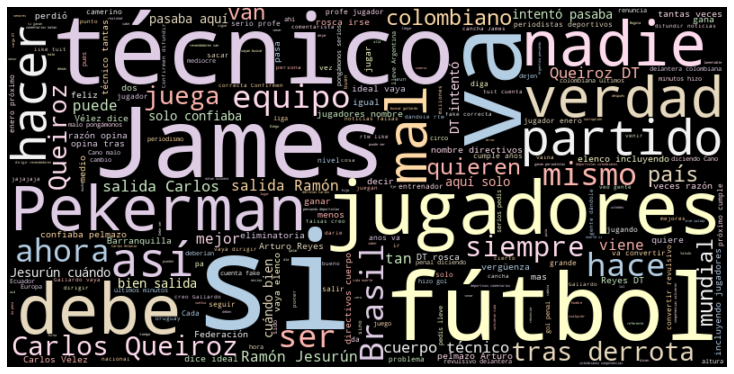

In [47]:
palabras = df_negativo.clean.str.cat(sep=" ")
wordcloud = WordCloud(width=800, height=400,
                     max_font_size=150, max_words=250,
                     background_color='black', colormap='Pastel1',
                     stopwords=stopwords).generate(palabras)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()